# TP4 *Introduction to Deep Learning* - Double L2 IA \& Sciences des Organisations
## Convolutional Neural Networks

This practical session focuses on Convolutional Neural Networks (CNNs). In the first part, the goal is to better understand the main components of CNNs (the *convolution*, *padding* and *pooling* operators) through simple visual examples that illustrate how these operations transform input images. The second part puts into practice the concepts explored in class and in the first part, and consists of implementing and training a CNN using PyTorch to solve an image classification task.

# Part I: Convolution and pooling operations with images

## 1. Setup

In [ ]:
%matplotlib inline
import math,sys,os,numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt

In [ ]:
import torch
import torchvision
from torchvision import models,transforms,datasets

As in the previous TPs, we will be working with the MNIST dataset. 

Some reminders:
- The MNIST dataset consists of small grayscale images of handwritten digits. Each image has a size of 28 x 28 pixels. There are 60,000 training images and 10,000 test images.
- ```torchvision.datasets``` provides support (download, formatting) for a collection of popular datasets. The list of available datasets in ```torchvision``` can be found [here](http://pytorch.org/docs/master/torchvision/datasets.html).
- The download of dataset using torchivision is performed only once. The function will always check first whether the data is already on disk.

In [ ]:
root_dir = './data/MNIST/'
torchvision.datasets.MNIST(root=root_dir,download=True) #si il voit qu'il est pas là, il le télécharge (download = True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/MNIST/
    Split: Train

In [ ]:
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, download=True) #charge 60000 données d'entrainement de MNIST

We define and initialize a data loader for the MNIST data downloaded on disk.

In [ ]:
MNIST_dataset = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=1) #dataloader : structure qui permet d'itérer facilement

We format data as _numpy ndarrays_ which are easier to plot in matplotlib, but the same operations can also be performed on _PyTorch Tensors_.

In [ ]:
images = train_set.data.numpy().astype(np.float32)/255
labels = train_set.targets.numpy()

In [ ]:
images.shape #60000 images, chacune de taille 28*28

(60000, 28, 28)

In [ ]:
labels.shape #même nb que nb d'images. Juste un entier entre 0 et 9

(60000,)

## 2. Data visualization

We implement below some functions to format and plot our image data.

In [ ]:
def plots(ims, interp=False, titles=None): #pour afficher PLUSIEURS images
    # Plot multiple images ('ims')
    ims = np.array(ims)
    mn,mx = ims.min(), ims.max()
    f = plt.figure(figsize=(12, 24))
    for i in range(len(ims)):
        sp = f.add_subplot(1, len(ims), i+1)
        if not titles is None: 
            sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none', vmin=mn, vmax=mx)

def plot(im, interp=False):
    # Plot a single image ('im')
    f = plt.figure(figsize=(3,6), frameon=True)
    plt.imshow(im, interpolation=None if interp else 'none')

plt.gray()
plt.close()

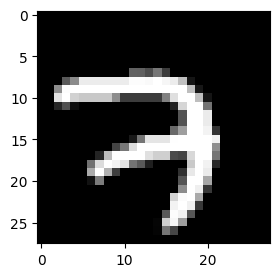

In [ ]:
plot(images[5000])

In [ ]:
labels[5000]

np.int64(7)

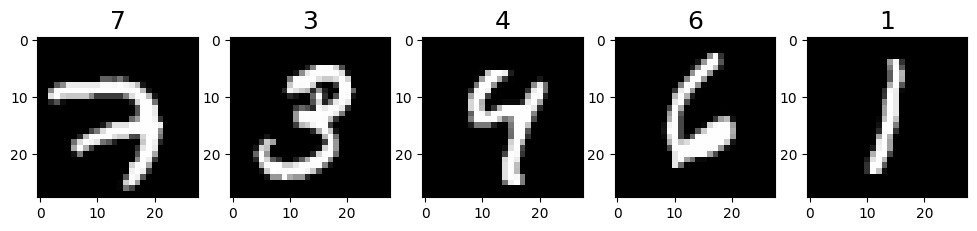

In [ ]:
plots(images[5000:5005], titles=labels[5000:5005])

## 3. A simple classifier

We will construct a simple binary classifier to detect whether a given image depicts a one or an eight. (assez facile car généralement, pas d'ambiguité)

We first extract all images belonging to the one and eight classes from the dataset.

In [ ]:
n = len(images)

In [ ]:
eights = [images[i] for i in range(n) if labels[i] == 8]
ones = [images[i] for i in range(n) if labels[i] == 1]

In [ ]:
len(eights), len(ones) #5851 images qui correspondent à un 8 et 7742 images qui corrrespondent à un 1

(5851, 6742)

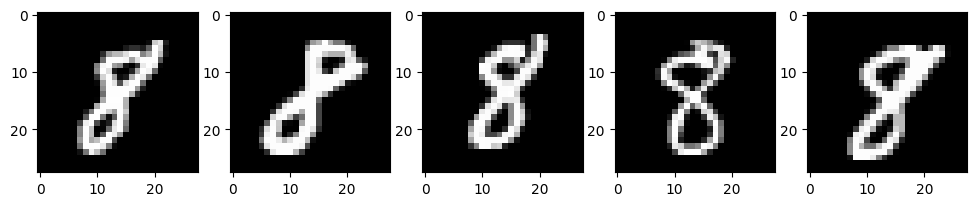

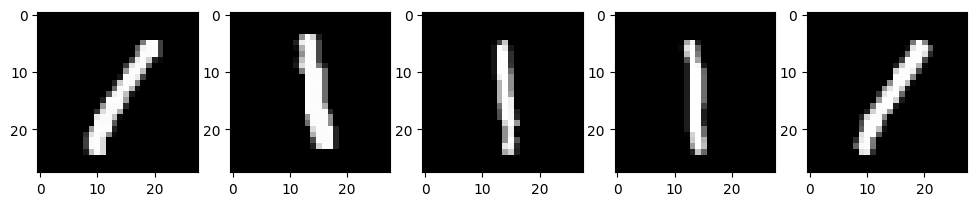

In [ ]:
plots(eights[:5])
plots(ones[:5])

For each class, we keep the first 1000 digits for the test set and we average all the remaining digits.

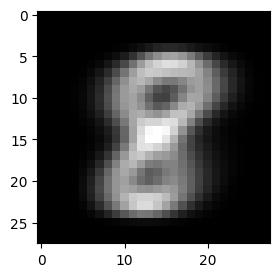

In [ ]:
raws8 =  np.mean(eights[1000:],axis=0) #donne une imgage moyennée, sans les 1000 premiers 8 qu'on garde pour le test
plot(raws8)

On a une seule image qui résume l'ensemble

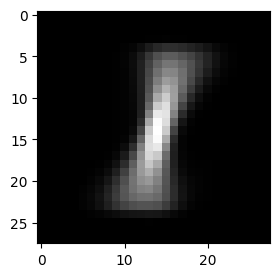

In [ ]:
raws1 =  np.mean(ones[1000:],axis=0)
plot(raws1)

We built above a 'typical representative' for the eights and another for the ones. 

Next, for a new sample from the test set, we compute its distance to each of the two representatives and assign it the label of the closest one. As a distance metric between images, we simply use the pixel-wise squared difference.

On va calculer la distance entre le proto de 8 et 1, et l'image qu'on veut prédire

In [ ]:
def sse(a,b): 
    # Sum of squared distance
    return ((a-b)**2).sum()

def is8_raw_n2(im):
    # Returns 1 if closest to 8 and 0 otherwise
    if sse(im,raws1) > sse(im,raws8):
        return 1
    else:
        return 0

Si je prédis 8 --> classe 1

Si je prédis 1 --> classe 0

In [ ]:
nb_8_predicted_8, nb_1_predicted_8 = [np.array([is8_raw_n2(im) for im in ims]).sum() for ims in [eights[:1000],ones[:1000]]]

nb_8_predicted_1, nb_1_predicted_1 = [np.array([(1-is8_raw_n2(im)) for im in ims]).sum() for ims in [eights[:1000],ones[:1000]]]

# just to check 
print(nb_8_predicted_1 + nb_8_predicted_8, nb_1_predicted_1 + nb_1_predicted_8)

1000 1000


Two important metrics in classification: **Precision and Recall**

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/1024px-Precisionrecall.svg.png" alt="Drawing" style="width: 500px;"/>

*Image source: [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)*

Pour un test sur une maladie (cancer) : faux positif beaucoup moins grave que faux négatif. On va donc plutôt utiliser le rappel comme métrique.

In [ ]:
def compute_scores(nb_8_predicted_8, nb_8_predicted_1, nb_1_predicted_1, nb_1_predicted_8):
    Precision_8 = nb_8_predicted_8 / (nb_8_predicted_8 + nb_1_predicted_8)
    Recall_8 = nb_8_predicted_8 / (nb_8_predicted_1 + nb_8_predicted_8)
    Precision_1 = nb_1_predicted_1 / (nb_1_predicted_1 + nb_8_predicted_1)
    Recall_1 = nb_1_predicted_1 / (nb_1_predicted_1 + nb_1_predicted_8)
    return Precision_8, Recall_8, Precision_1, Recall_1

Precision_8, Recall_8, Precision_1, Recall_1 = compute_scores(nb_8_predicted_8, nb_8_predicted_1, nb_1_predicted_1, nb_1_predicted_8)

print('precision 8:', Precision_8, 'recall 8:', Recall_8)
print('precision 1:', Precision_1, 'recall 1:', Recall_1)
print('accuracy :', (Recall_1+Recall_8)/2)

precision 8: 0.9712460063897763 recall 8: 0.912
precision 1: 0.9170593779453345 recall 1: 0.973
accuracy : 0.9425


94% d'images correctement prédites. Pas mal. Mais on peut l'améliorer, et c'est ce score qu'on veut améliorer avec le ML.

This simple approach serves as our baseline for the binary classification task. 

**The goal of this TP is to improve upon it by using convolutional, padding and pooling operations.**

First, let us better understand such operations.

## 4. Kernels, convolutions and padding

Check the visual explanation here: [Interactive image kernels](http://setosa.io/ev/image-kernels/)

In some fields, convolution or filtering is better understood as _correlations_. 
In practice, we slide the kernel (or filter) matrix over the image (a larger matrix), always selecting patches from the image that are the same size as the filter. At each position, we compute the dot product between the filter and the image patch and store the resulting scalar. This value reflects the degree of similarity (or correlation) between the kernel and the image patch.

Here is a simple 3 x 3 kernel, which corresponds to a matrix of size 3 x 3. See [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) for more examples.

Lien : Image avec valeurs entre 0 (noir) et 255 (blanc)

Sharpen : renforce les contrastes, blur : rend flou

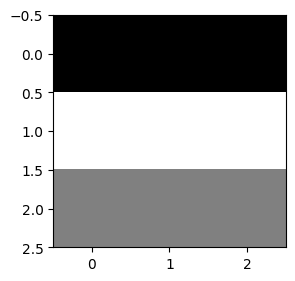

In [ ]:
top=[[-1,-1,-1],
     [ 1, 1, 1],
     [ 0, 0, 0]]

plot(top)

We now create a toy image, to understand how convolutions operate.

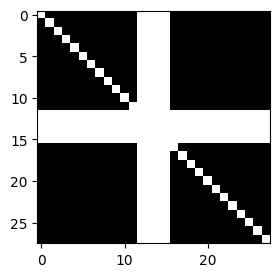

In [ ]:
cross = np.zeros((28,28))
cross += np.eye(28)
for i in range(4):
    cross[12+i,:] = np.ones(28)
    cross[:,12+i] = np.ones(28)

plot(cross)

Our `top` filter should highlight top horizontal border in the image.

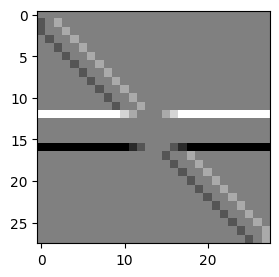

In [ ]:
from scipy.ndimage import convolve, correlate

corr_cross = correlate(cross,top) #fonction déjà def dans scipy. On entre en paramètre notre image et notre filtre.

plot(corr_cross)

c'est gris parce qu'on fait -1(-1)+(-1)(-1)+(-1)(-1) + (-1)1+ (-1)1 + (-1)1 = 0

Dès qu'on a que du gris, ou que du noir, on obtient du gris

In [ ]:
# Documentation on 'correlate'
?correlate

Signature:
correlate(
    input,
    weights,
    output=None,
    mode='reflect',
    cval=0.0,
    origin=0,
    *,
    axes=None,
)
Docstring:
Multidimensional correlation.

The array is correlated with the given kernel.

Parameters
----------
input : array_like
    The input array.
weights : ndarray
    array of weights, same number of dimensions as input
output : array or dtype, optional
    The array in which to place the output, or the dtype of the
    returned array. By default an array of the same dtype as input
    will be created.
mode : {'reflect', 'constant', 'nearest', 'mirror', 'wrap'}, optional
    The `mode` parameter determines how the input array is extended
    beyond its boundaries. Default is 'reflect'. Behavior for each valid
    value is as follows:

    'reflect' (`d c b a | a b c d | d c b a`)
        The input is extended by reflecting about the edge of the last
        pixel. This mode is also sometimes referred to as half-sample
        symmetric.

    'con

The **padding** operation handles the borders of the image during convolution. Since filters need to slide over the entire image, padding is used to add extra pixels (usually zeros) around the edges, allowing the filter to be applied to border regions without reducing the output size too much.

![padding](https://dataflowr.github.io/notebooks/Module6/img/padding_conv.gif)

*Image source: [Convolution animations](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)*

Let's visualize the impact of padding on our previous example.

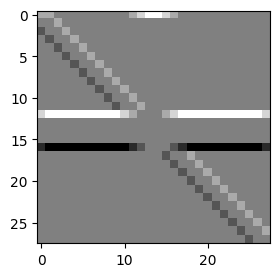

In [ ]:
corr_cross = correlate(cross, top, mode='constant')
plot(corr_cross)

Now, let us go back to MNIST dataset and check the effect of the previous filter.

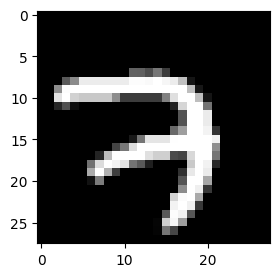

In [ ]:
plot(images[5000])

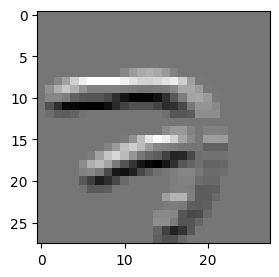

In [ ]:
corrtop = correlate(images[5000], top)
plot(corrtop)

Convolution and correlation are related operations, but they differ slightly in how they are defined and applied: by rotating the filter 180 degrees (meaning flipping the filter in the two dimensions) and calling the ```convolve``` function, we get the same response as with the previously called ```correlate``` function. 

In [ ]:
np.rot90(top, 2)

array([[ 0,  0,  0],
       [ 1,  1,  1],
       [-1, -1, -1]])

In [ ]:
np.array(top)

array([[-1, -1, -1],
       [ 1,  1,  1],
       [ 0,  0,  0]])

True

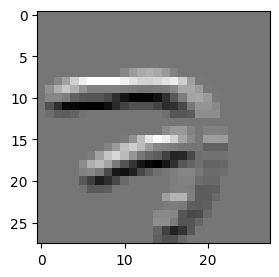

In [ ]:
convtop = convolve(images[5000], np.rot90(top, 2))
plot(convtop)
np.allclose(convtop, corrtop)

Let's generate a few more variants of our simple 3 x 3 filter.

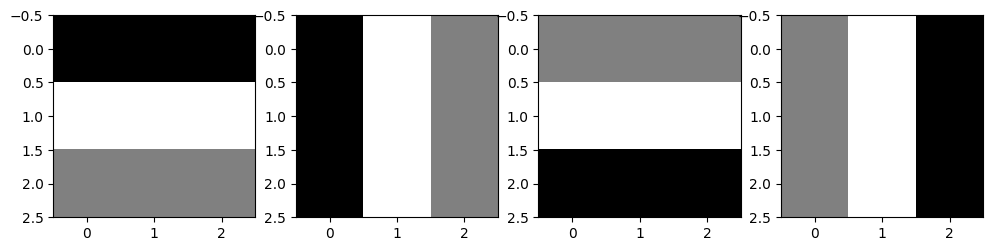

In [ ]:
straights=[np.rot90(top, i) for i in range(4)]
plots(straights)

We proceed similarly to generate a set of filters with a different behavior. On fait 4 fois la même rotation, et on obtient 4 filtres différents.

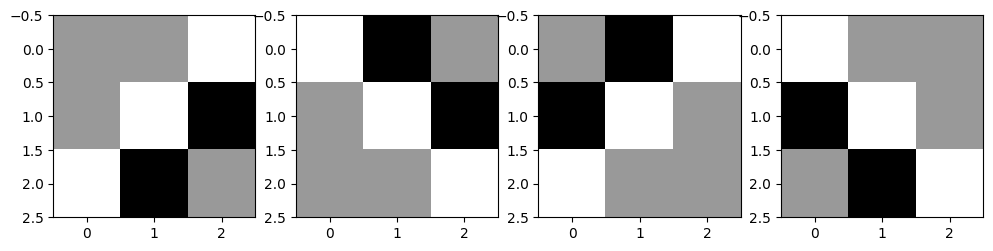

In [ ]:
br=[[ 0, 0, 1],
    [ 0, 1,-1.5],
    [ 1,-1.5, 0]]

diags = [np.rot90(br,i) for i in range(4)]
plots(diags)

We can compose filters to obtain more complex patterns

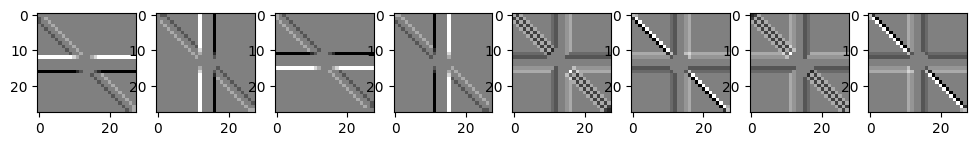

In [ ]:
rots = straights + diags
corrs_cross = [correlate(cross, rot) for rot in rots]
plots(corrs_cross)

2ème met en valeur les bords verticaux, plus que la première qui met en val les bords horizontaux

Feature maps : il y en a autant qu'on a défini de kernels. 8 kernel, 8 feature maps. 

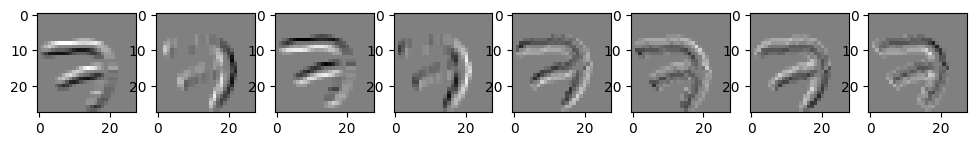

In [ ]:
rots = straights + diags
corrs = [correlate(images[5000], rot) for rot in rots]
plots(corrs)

## 5. Pooling

Next, we illustrate the effect of downsampling using the most basic technique: __max pooling__. This method consists in keeping only the maximum value from each sliding windows of size ```7 x 7```.

__Max pooling__ offers several key advantages:
- Since it selects the maximum values within each window, it ensures invariance to translations, meaning the network can recognize features regardless of small shifts in position.
- By reducing the size of the image, it makes the data more compact, which simplifies comparisons and reduces computational costs.
- Since max pooling reduces the image size, it allows the subsequent layers in the network to have a larger receptive field. This means the later layers consider a larger patch of the original image, whichs allows identify higher-level patterns.

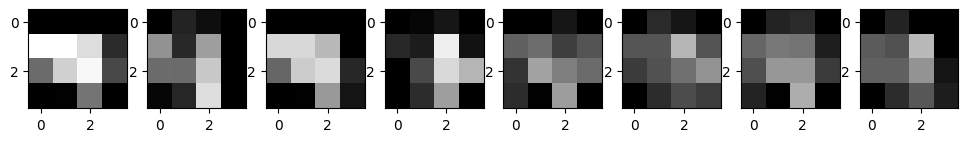

In [ ]:
import skimage

from skimage.measure import block_reduce

def pool(im): 
    return block_reduce(im, (7,7), np.max)

plots([pool(im) for im in corrs])

## 6. A convolution-based classifier

We now build a new classifier using the operations described above.

To this end, we select a set of training images depicting _eights_ and _ones_, we convolve them with our set of filters, apply max pooling, and average the pooled values for each class and each filter. This process will give us a set of _representative_ feature signatures for both _eights_ and _ones_.

For a new test image, we compute its features by convolving and pooling it with the same filters, then compare the computed features with the representative features. The class with the most similar features is chosen as the prediction.

As before, for each class, we use 1000 images for the test set and the remaining images for training. We convolve these training images with our bank of filters, perform max pooling on the responses, and store them in ```pool8``` (for class _eight_) and ```pool1``` (for class _one_).

In [ ]:
pool8 = [np.array([pool(correlate(im, rot)) for im in eights[1000:]]) for rot in rots]

In [ ]:
len(pool8), pool8[0].shape

(8, (4851, 4, 4))

We plot the result of the first filter+pooling on the first 5 _eights_ in our set. 

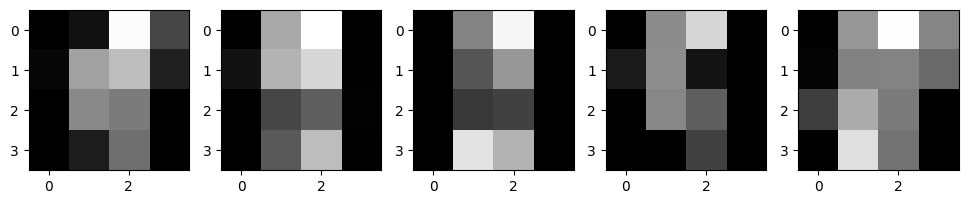

In [ ]:
plots(pool8[0][0:5])

For the 4 first _eights_ in our set, we plot the result of the 8 filters+pooling

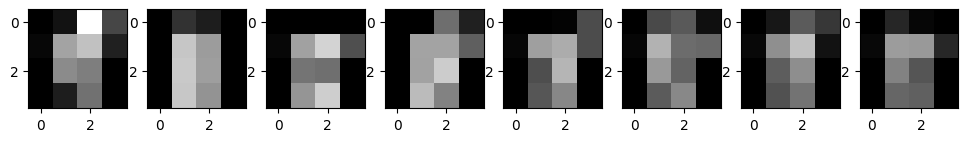

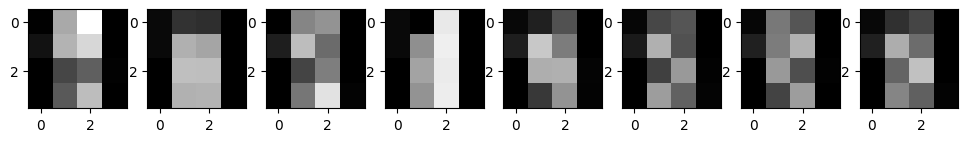

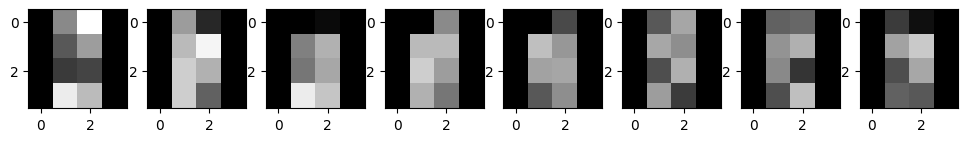

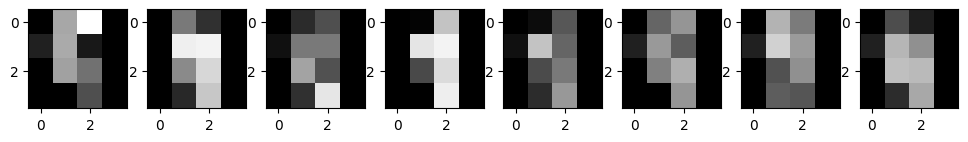

In [ ]:
plots([pool8[i][0] for i in range(8)])
plots([pool8[i][1] for i in range(8)])
plots([pool8[i][2] for i in range(8)])
plots([pool8[i][3] for i in range(8)])

We normalize the data to smooth the activations and scale them to similar ranges of values.

In [ ]:
def normalize(arr): 
    return (arr - arr.mean()) / arr.std()

Next, we compute the average _eight_ by averaging all responses for each filter from _rots_.

In [ ]:
filts8 = np.array([ims.mean(axis=0) for ims in pool8])
filts8 = normalize(filts8)

We should obtain a set of canonical _eight_ responses for each filter.

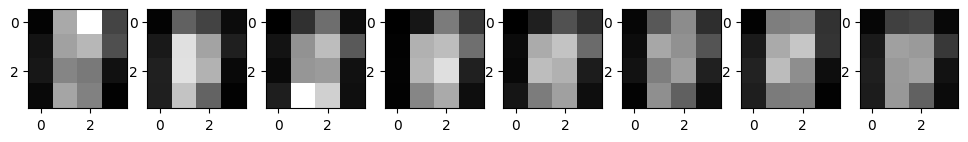

In [ ]:
plots(filts8)

We proceed similarly with training samples from the _one_ class and plot the canonical _ones_.

In [ ]:
pool1 = [np.array([pool(correlate(im, rot)) for im in ones[1000:]]) for rot in rots]
filts1 = np.array([ims.mean(axis=0) for ims in pool1])
filts1 = normalize(filts1)

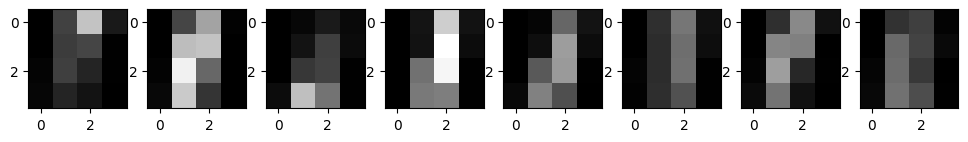

In [ ]:
plots(filts1)

**Question.** Do you notice any differences between ```filts8``` and ```filts1```? Which ones?

Plus de blanc dans les caractéristiques du 8. Logique. Les 1 sont plus verticaux

The following function correlates a given image with all filters from ```rots``` and applies max pooling to the responses.

In [ ]:
def pool_corr(im): 
    return np.array([pool(correlate(im, rot)) for rot in rots])

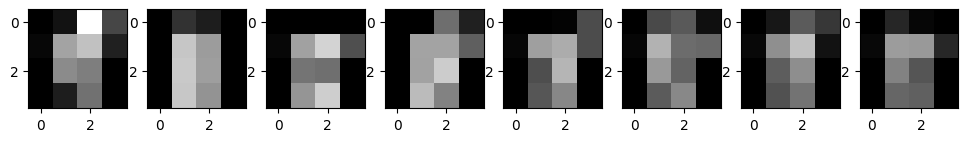

In [ ]:
plots(pool_corr(eights[1000]))

True

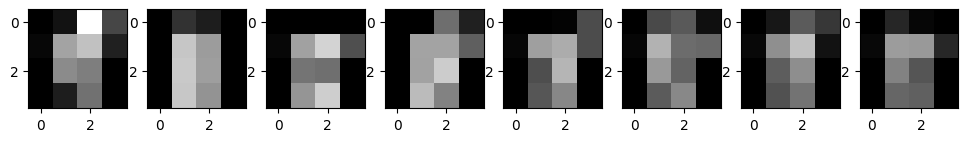

In [ ]:
# safety check
plots([pool8[i][0] for i in range(8)])
np.allclose(pool_corr(eights[1000]), [pool8[i][0] for i in range(8)])

The following function is used for a voting-based classifier that determines the most likely class (either of the two classes) based on the sum of squared errors (SSE) distances. The function is8_n2 returns 1 if the classifier predicts the image as an _eight_ and 0 otherwise.

In [ ]:
def is8_n2(im):
    if sse(pool_corr(im), filts1) > sse(pool_corr(im),filts8):
        return 1
    else: 
        return 0

We perform a test to verify if our function works correctly: we correlate an image of an _eight_ with ```filts8``` and ```filts1```. The distance should be smaller for the _eights_.

In [ ]:
sse(pool_corr(eights[0]), filts8), sse(pool_corr(eights[0]), filts1)

(np.float32(103.67323), np.float32(126.09805))

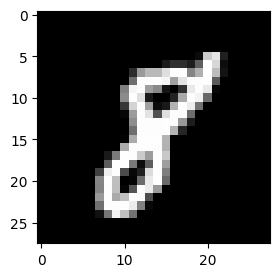

In [ ]:
plot(eights[0])

We now test our classifier on the 1000 images of _eights_ and 1000 images of _ones_

In [ ]:
nb_8_predicted_8, nb_1_predicted_8 = [np.array([is8_n2(im) for im in ims]).sum() for ims in [eights[:1000],ones[:1000]]]

nb_8_predicted_1, nb_1_predicted_1 = [np.array([(1-is8_n2(im)) for im in ims]).sum() for ims in [eights[:1000],ones[:1000]]]

In [ ]:
Precisionf_8, Recallf_8, Precisionf_1, Recallf_1 = compute_scores(nb_8_predicted_8,nb_8_predicted_1,nb_1_predicted_1,nb_1_predicted_8)

print('precision 8:', Precisionf_8, 'recall 8:', Recallf_8)
print('precision 1:', Precisionf_1, 'recall 1:', Recallf_1)
print('accuracy :', (Recallf_1+Recallf_8)/2)
print('accuracy baseline:', (Recall_1+Recall_8)/2)

precision 8: 0.963220675944334 recall 8: 0.969
precision 1: 0.9688128772635815 recall 1: 0.963
accuracy : 0.966
accuracy baseline: 0.9425


We observe that we improved the accuracy while reducing the embedding size from a $28\times 28 = 784$ vector to a $4\times 4\times 8 = 128$ vector.

To conclude, we have successfully built a classifier for _eights_ and _ones_ using features extracted with a bank of pre-defined features and a set of training samples. 

## Part II: Improving classification with Convolutional Neural Networks

In this second part, you will build a neural network that learns the weights of the filters.

The first layer of your network will be a convolutional layer with $8$ filters of size $3 \times 3$. Then, you will apply a Max Pooling layer to reduce the image size to $4\times 4$, as we did earlier. This will result in a flattened vector of size $128 = 4\times 4\times 8$. From this vector, you will predict if the input corresponds to a $1$ or an $8$. This brings you back to a classification problem.

**Question 1.** Complete the code below to construct this CNN.For further details, you can refer to [torch.nn](https://pytorch.org/docs/stable/nn.html) in the PyTorch documentation. 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    def __init__(self):
        super(classifier, self).__init__()
        # To complete
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=?)
        self.fc = nn.Linear(in_features=?, out_features=?)
        
    def forward(self,x):
        x = self.conv1(x)
        # To complete
        return x

In [ ]:
conv_class = classifier()

**Q2.** Test your implementation on a batch of 3 images.

In [ ]:
batch_3images = train_set.data[0:2].type(torch.FloatTensor).resize_(3, 1, 28, 28)
# TO COMPLETE

The following lines of code implement a data loader for the train set and the test set (no modification is needed).

In [ ]:
bs = 64

l8 = np.array(0)
eights_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), torch.from_numpy(l8.astype(np.int64))] for e in eights]
l1 = np.array(1)
ones_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), torch.from_numpy(l1.astype(np.int64))] for e in ones]
train_dataset = eights_dataset[1000:] + ones_dataset[1000:]
test_dataset = eights_dataset[:1000] + ones_dataset[:1000]

train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=bs, shuffle=True)

**Q3.** Complete the following code to train your CNN. Store the loss and accuracy for each epoch.

In [ ]:
def train(model,data_loader,loss_fn,optimizer,n_epochs=1):
    model.train(True)
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    for epoch_num in range(n_epochs):
        running_corrects = 0.0
        running_loss = 0.0
        size = 0

        for data in data_loader:
            inputs, labels = data
            bs = labels.size(0)
            # TO COMPLETE
            size += bs
        epoch_loss = running_loss.item() / size
        epoch_acc = running_corrects.item() / size
        loss_train[epoch_num] = epoch_loss
        acc_train[epoch_num] = epoch_acc
        print('Train - Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return loss_train, acc_train

**Q4.** Choose the appropriate loss and select the SGD optimizer.

In [ ]:
conv_class = classifier()
loss_fn = # TO COMPLETE
learning_rate = 1e-3
optimizer_cl = # TO COMPLETE

We train the CNN for 10 epochs.

In [ ]:
l_t, a_t = train(conv_class,train_loader,loss_fn,optimizer_cl,n_epochs = 10)

Repeat the process for 10 more epochs and verify that your model seems to learn.

In [ ]:
l_t1, a_t1 = train(conv_class,train_loader,loss_fn,optimizer_cl,n_epochs = 10)

**Q5.** Complete the test procedure to evaluate your model in terms of accuracy.

In [ ]:
def test(model,data_loader):
    model.train(False)

    running_corrects = 0.0
    running_loss = 0.0
    size = 0

    for data in data_loader:
        inputs, labels = data
            
        bs = labels.size(0)
        # TO COMPLETE
        size += bs

    print('Test - Loss: {:.4f} Acc: {:.4f}'.format(running_loss / size, running_corrects.item() / size))

In [ ]:
test(conv_class,test_loader)

**Q6.** Change the optimizer to Adam and compare with respect to the previous method (SGD).

In [ ]:
# TO COMPLETE

**Q7**. How many parameters did your network learn?

In [ ]:
# TO COMPLETE

You can see them as follows:

In [ ]:
for m in conv_class.children():
    print('weights :', m.weight.data)
    print('bias :', m.bias.data)

In [ ]:
for m in conv_class.children():
    T_w = m.weight.data.numpy()
    T_b = m.bias.data.numpy()
    break

In [ ]:
plots([T_w[i][0] for i in range(8)])

In [ ]:
T_b

In [ ]:
# TP inspired by M. Lelarge